# Real-Time Optimization Investigation
## Modifier Adaptation with Bayesian Optimization using EIC acquisition

In [31]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform, generate_samples_lhs
from rto.experiment.analysis import ExperimentAnalyzer

MEMORY_DATABASE = "file::memory:?cache=shared"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [3]:
# Define the input domain
grid_size = 50
g0 = 0.12
g1 = 0.08

u1 = np.linspace(3, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)
    zz_g1 = g[:,1].reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

z_plant, g0_plant, g1_plant = get_grid_values(plant, xx, yy)
z_model, g0_model, g1_model = get_grid_values(model, xx, yy)
g_plant = (g1_plant < g1)&(g0_plant < g0)
g_model = (g1_model < g1)&(g0_model < g0)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

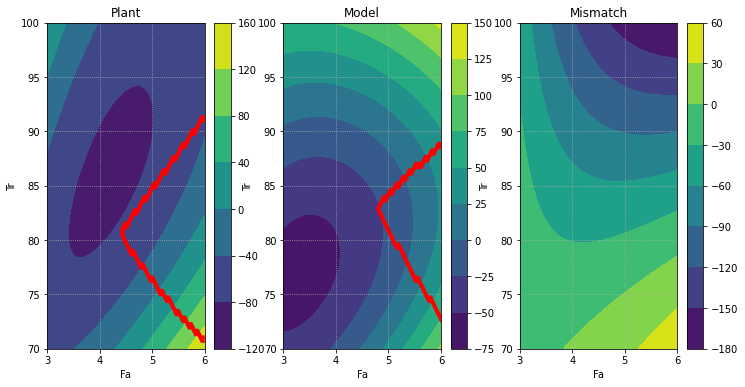

In [4]:
# Plot the decision surface
fig, ax = plt.subplots(1, 3, figsize=(12,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title):
    if(z_f is not None):
        ax.contour(xx, yy, z_f, colors='red')
    CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Model')
plot_decision_surface(fig, ax[2], xx, yy, None, z_plant - z_model, 'Mismatch')

fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

In [5]:
ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 4.39215628 80.66134787], f*=-75.80539963789442
Model: u*=[ 4.78861183 83.20554018], f*=-26.1743183819965


Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

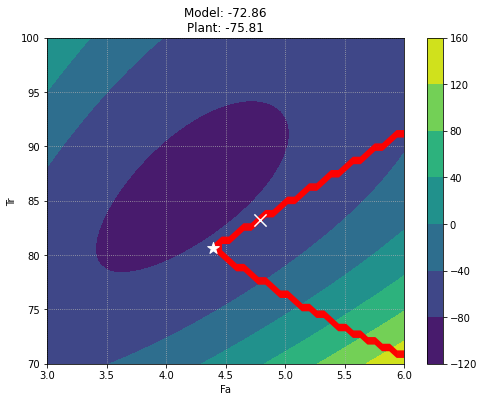

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='x', s=150, zorder=5)
fig.show()

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

### EIC acquisition function

There is a clear link between RTO and Bayesian optimization. Both problems try to optimize and unknown and expensive-to-evaluate function by sampling it according to some heuristics. The main difference lies in the fact that the Bayesian framework is purely data-drive, while in RTO we have a model that, although imperfect, captures the main behavior of the unknown function. Notice that this works as some sort of *prior* knowledge, which in the Bayesian frameork could be historical samples of the function to be optimized, for example.

Considering the MA-GP scheme, one can see that the RTO system learns the plant-model mismatch using GPs and the prior knowledge of the model is used to drive plant optimization. In the Bayesian framework, this is achieved with the use of so-called acquisition functions. Therefore, one could ask the following question: what if we included the acquisition function in RTO procedure? Could this improve the system's performance? 

This was already done by [XX], which applied an EI acquisition to the objective, but used derivative-free and trust-region concepts to handle constrained problems. The idea behind this is to reduce or increase the trust-region size based on thje discrepancy between model estimations and plant measurements. But, one can clearly see that embedding a fully constrained Bayesian framework could be easily achieved. We can change the model-based optimization problem to use the EIC acquisition function, since we have GPs already trained on the constraints mismatch. This turns our constrained problem into a unconstrained one, using a barrier-like objective function.

In [34]:
# creates a memory database to be used in this tutorial
!python ../scripts/create_database.py -m

Created memory database succesfully


First, let's run the optimization problem with the EIC acquisition function, using the same default parameters for GP learning. We also run MA-GP as a baseline to compare the results. The last sampled initial operating point is used to start the system. For now, only the noiseless case is considered, to avoid unexpected effects.

In [77]:
# Define the system parameters
u_0 = u_model
iterations = 30
noise = 0.00
initial_data_size = 5

# sample some initial data
u, y, measurements = generate_samples_uniform(model, plant, g, u_0, initial_data_size, noise=noise)
initial_data = Bunch(u=u, y=y, measurements=measurements)

# create the adaptation strategy
adaptation = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
optimizer_ma = ModifierAdaptationOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

adaptation_bay = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de'}, backoff=0.0)

rto = RTO(model, plant, optimizer_ma, adaptation, iterations, db_file=MEMORY_DATABASE, name='MA-GP', noise=noise)
rto_bay = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian', noise=noise)

/home/victor/miniconda3/envs/rto-debug/lib/python3.9/site-packages/rto/utils.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meas_initial.append(np.array([fr, gr, fm, gm]))


In [78]:
u_0_feas = u[-1]
for i in range(1):
    rto_bay.run(u_0_feas)
    rto.run(u_0_feas)

TypeError: scipy.optimize._differentialevolution.differential_evolution() got multiple values for keyword argument 'atol'

In [37]:
# load the results
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results = analyzer.load('MA-GP')
results_tr = analyzer.load('MA-GP-Bayesian')

results_processed = analyzer.pre_process(results, f_plant, u_plant)
results_processed_tr = analyzer.pre_process(results_tr, f_plant, u_plant)

results_all = pd.concat([results_processed, results_processed_tr], ignore_index=True)

Below the results for the cost and input optimality gap are displayed. Notice that using the proposed Bayesian framework, we achieve similar results as the MA-GP baseline. However, the Bayesian approach presents more variability during the optimization steps, we could be related to the way we penalize the constraints violations. As seen previously, the optimal point will lie exactly at the intersection of two constraints, which poses a challenge for the RTO system. 

Another angle is to understand how the EIC acquisition function balances exploration and explotation. Maybe there is some exploitation happening when it shouldn't.

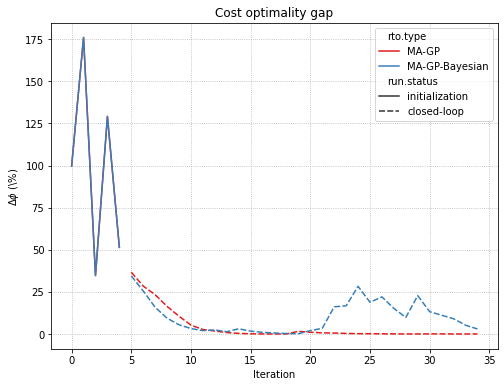

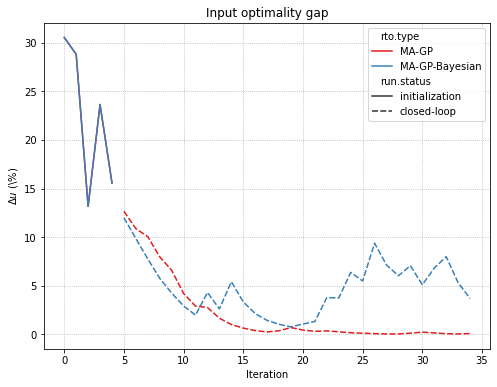

In [38]:
_ = analyzer.plot_by_iteration(results_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

Having a further look at the constraints, we can observer an interesting situation: using the EIC objective function, there is a high penalty for violating constraints. Whenever any of them are violated, there next solution found is biased towards this result, causing the system to be driven away from the unfeasible region. This is an interesting property, but it can prevent it from converging to the acutal plant optimum, specially if it lies at non-empty set of active constraints.

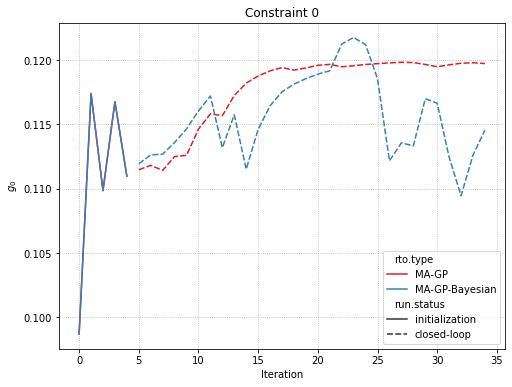

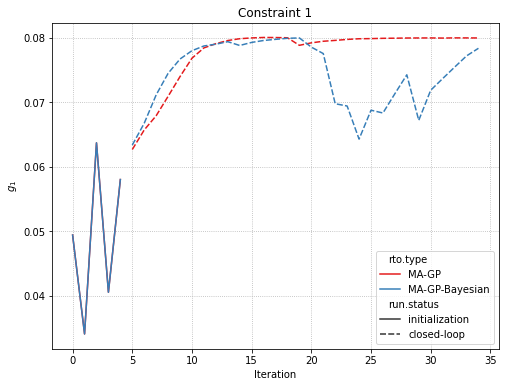

In [39]:
_ = analyzer.plot_by_iteration(results_all, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_all, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

In the figure below, the contour plot shows the observer scenario: there is a bump once the Bayesian RTO finds an unfeasible solution, which keeps it inside the feasible region. On the other hand, MA-GP oscilattes around the plant optimum, but at the cost of more constraints violation.

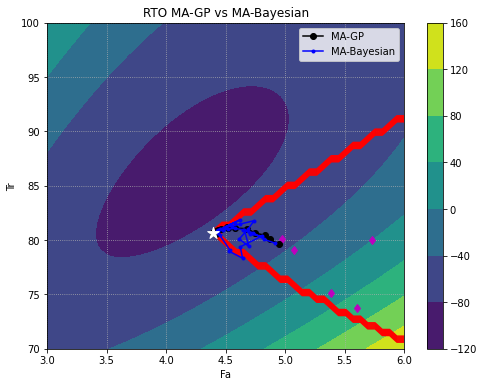

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, 'RTO MA-GP vs MA-Bayesian')
u_rto = np.stack(results_processed['u'], axis=0)
u_rto_init = u_rto[:initial_data_size, :]
u_rto = u_rto[initial_data_size:, :]

u_rto_tr = np.stack(results_processed_tr['u'], axis=0)
u_rto_init_tr = u_rto_tr[:initial_data_size, :]
u_rto_tr = u_rto_tr[initial_data_size:, :]

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)
line1, = ax.plot(u_rto[:,0], u_rto[:,1], 'ko-', zorder=4)
line2, = ax.plot(u_rto_tr[:,0], u_rto_tr[:,1], 'b.-', zorder=5)

ax.legend((line1, line2), ('MA-GP','MA-Bayesian'))

fig.show()

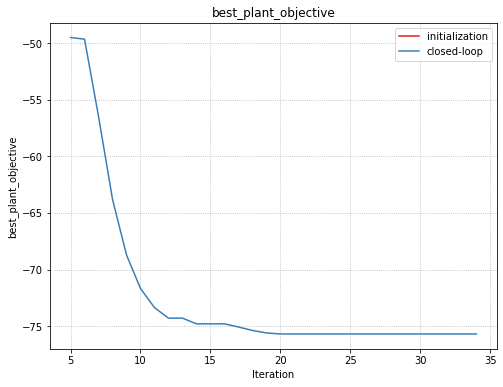

In [42]:
_ = analyzer.plot_by_iteration(results_processed_tr, 'best_plant_objective', 'best_plant_objective', 'best_plant_objective')
# fig, ax = plt.subplots()
# ax.plot(results_processed_tr['cost_real'],'r-')
# ax.plot(results_processed_tr['best_plant_objective'],'ko')

### Increasing the iteration amount of the RTO iterations
Let's see if the oscillating behavior is maintained after several RTO iterations.

In [43]:
rto_bay_60iter = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations=60, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian-60iter', noise=noise)
rto_bay_60iter.run(u_0)

3

Notice that this behavior prevents the Bayesian model from actually converging. Whenever it gets too close to a constraint, there is a bump to the next solution that drives it away from the plant optimum. It looks like we are loosing information from previous iterations, which leads to the next investigation: GP training data selection.

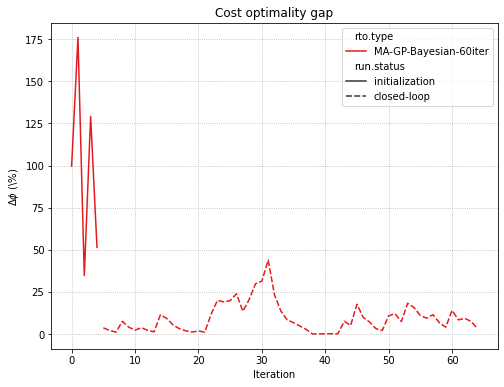

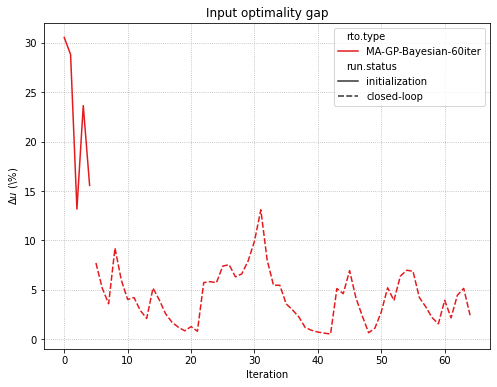

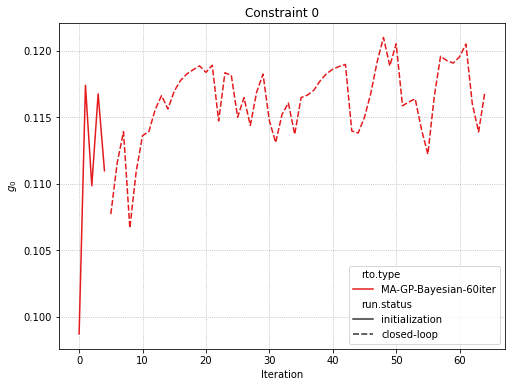

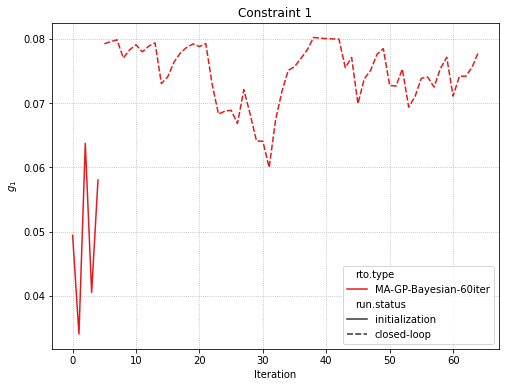

In [44]:
results_60iter = analyzer.load('MA-GP-Bayesian-60iter')
results_processed_60iter = analyzer.pre_process(results_60iter, f_plant, u_plant)
_ = analyzer.plot_by_iteration(results_processed_60iter, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed_60iter, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed_60iter, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed_60iter, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

### Playing around with GP training parameters

1. Increasing the number of data points to consider

In [45]:
adaptation_klast20 = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=False, neighbors_type='k_last', k_neighbors=20)
adaptation_klast40 = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=False, neighbors_type='k_last', k_neighbors=40)
adaptation_klast60 = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=False, neighbors_type='k_last', k_neighbors=60)

rto_bay_klast20 = RTOBayesian(model, plant, optimizer_bay, adaptation_klast20, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian-klast20', noise=noise)
rto_bay_klast40 = RTOBayesian(model, plant, optimizer_bay, adaptation_klast40, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian-klast40', noise=noise)
rto_bay_klast60 = RTOBayesian(model, plant, optimizer_bay, adaptation_klast60, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian-klast60', noise=noise)

rto_bay_klast20.run(u_0)
rto_bay_klast40.run(u_0)
rto_bay_klast60.run(u_0)

6

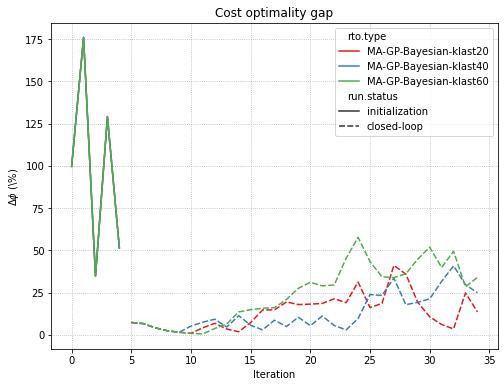

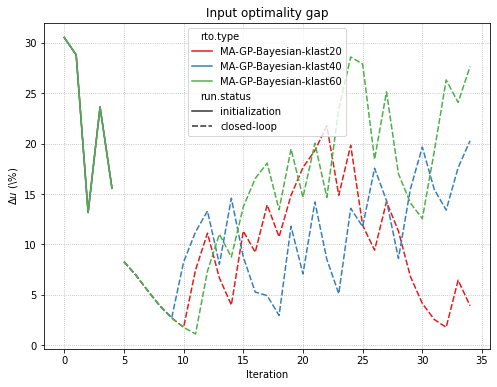

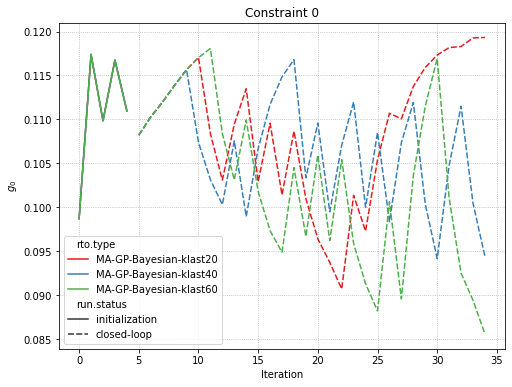

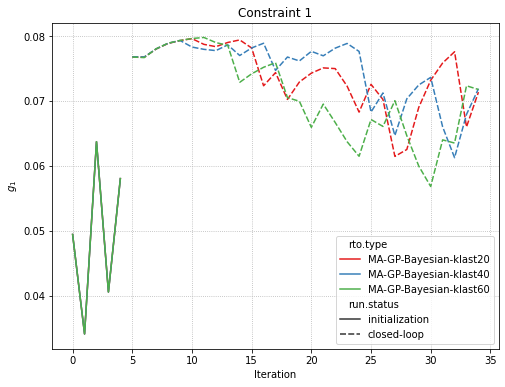

In [46]:
results_klast20 = analyzer.load('MA-GP-Bayesian-klast20')
results_klast40 = analyzer.load('MA-GP-Bayesian-klast40')
results_klast60 = analyzer.load('MA-GP-Bayesian-klast60')

results_klast20_processed = analyzer.pre_process(results_klast20, f_plant, u_plant)
results_klast40_processed = analyzer.pre_process(results_klast40, f_plant, u_plant)
results_klast60_processed = analyzer.pre_process(results_klast60, f_plant, u_plant)

results_klast_exp = pd.concat([results_klast20_processed, results_klast40_processed, results_klast60_processed], ignore_index=True)

_ = analyzer.plot_by_iteration(results_klast_exp, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_klast_exp, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_klast_exp, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_klast_exp, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

Looking at the results above, notice that increasing the amount of data used for training the GPs is actually a bad idea. There is even more variation if we try to bring more knowledge from the measurements. Let's have a look at the GP models on each iteration.

In [47]:
gp_iterations_20iter = [analyzer.load_run_models(run_id) for run_id in results_klast20_processed['run.id']]
gp_iterations_40iter = [analyzer.load_run_models(run_id) for run_id in results_klast40_processed['run.id']]
gp_iterations_60iter = [analyzer.load_run_models(run_id) for run_id in results_klast60_processed['run.id']]

In [48]:
def get_grid_predictions(models, xx, yy):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x) + fobj.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_0 = np.array([model.get_constraints(x)[0] + constraint0.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_1 = np.array([model.get_constraints(x)[1] + constraint1.predict(scaler.transform(x.reshape(1,-1))) for x in grid])

    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g_0.reshape(xx.shape)
    zz_g1 = g_1.reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

In [1]:
def plot_gp_surface(fig, ax, xx, yy, z_f, title):
    CS = ax.contour(xx, yy, z_f)
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

def plot_gp_predictions(ax, i, gp_iterations, xx, yy, title):
    f_gp, g0_gp, g1_gp = get_grid_predictions(gp_iterations[initial_data_size + i],xx,yy)
    g_gp = (g1_gp < g1)&(g0_gp < g0)
    plot_decision_surface(fig, ax, xx, yy, g_gp, f_gp, title)

fig, ax = plt.subplots(3,3,figsize=(12,12))

for i, itertrain in enumerate([5,15,25]):
    plot_gp_predictions(ax[i,0], itertrain, gp_iterations_20iter,xx,yy, f'k_neighbors=20: iter. {itertrain}')
    plot_gp_predictions(ax[i,1], itertrain, gp_iterations_40iter,xx,yy, f'k_neighbors=40: iter. {itertrain}')
    plot_gp_predictions(ax[i,2], itertrain, gp_iterations_60iter,xx,yy, f'k_neighbors=60: iter. {itertrain}')
    
    ax[0,i].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax[1,i].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax[2,i].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)

fig.tight_layout()

NameError: name 'plt' is not defined

In [75]:
def get_eic_grid(models, xx, yy, f_best):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    ei = []
    eic = []
    g0_probs = []
    g1_probs = []

    for x in grid:
        xs = scaler.transform(x.reshape(1,-1))
        model_obj = model.get_objective(x)
        model_g = model.get_constraints(x)

        adaptation = Bunch(modifiers=[fobj.predict(xs, return_std=True), constraint0.predict(xs, return_std=True), constraint1.predict(xs, return_std=True)])
        ei_f = optimizer_bay._ei_acquisition(model_obj, adaptation, f_best)

        ei.append(ei_f)
        probs = optimizer_bay._constraint_probability(model_g,adaptation)
        eic.append(ei_f*np.prod(probs))
        g0_probs.append(probs[0])
        g1_probs.append(probs[1])


    # reshape the predictions back into a grid
    zz_ei = np.array(ei).reshape(xx.shape)
    zz_g0 = np.array(g0_probs).reshape(xx.shape)
    zz_g1 = np.array(g1_probs).reshape(xx.shape)
    zz_eic = np.array(eic).reshape(xx.shape)

    return zz_ei, zz_g0, zz_g1, zz_eic

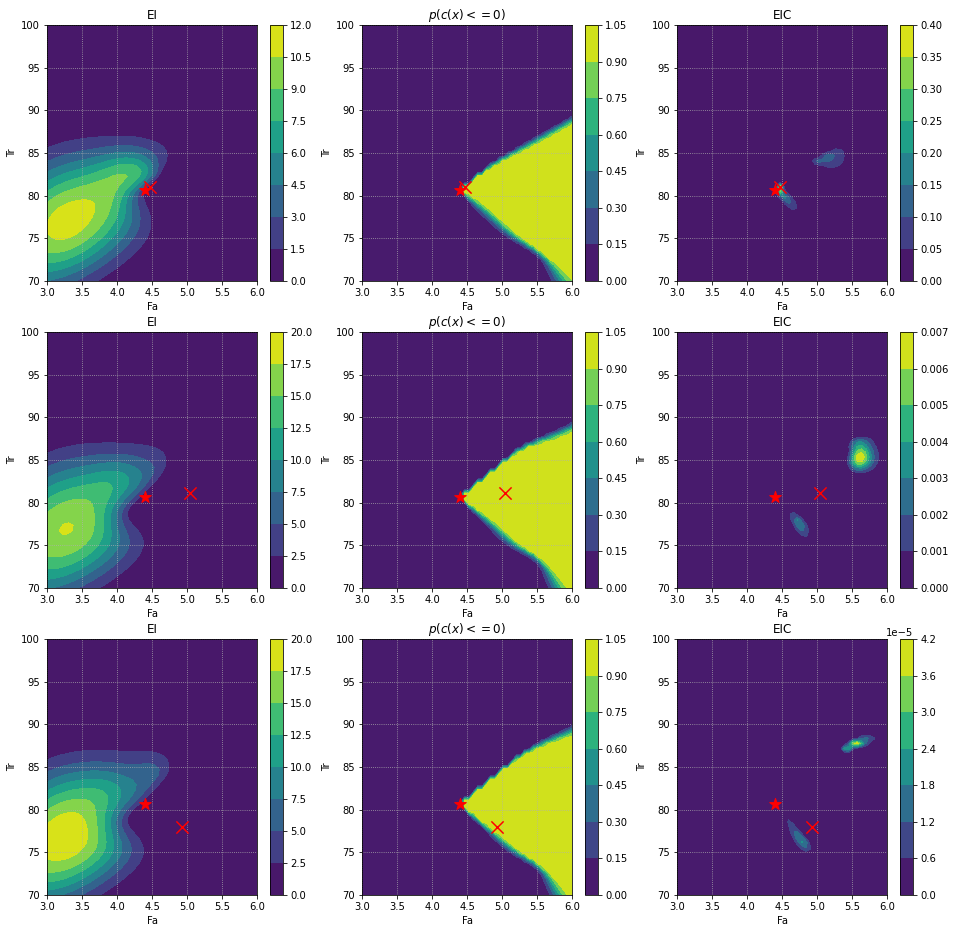

In [76]:
def plot_eic_grid(ax, i, best_solutions, gp_iterations, xx, yy, title):
    fbest = best_solutions.iloc[initial_data_size + i]
    f_gp, g0_gp, g1_gp, eic = get_eic_grid(gp_iterations[initial_data_size + i],xx,yy,fbest)
    plot_decision_surface(fig, ax[0], xx, yy, None, f_gp, 'EI')
    plot_decision_surface(fig, ax[1], xx, yy, None, g1_gp*g0_gp, '$p(c(x) <= 0)$')
    plot_decision_surface(fig, ax[2], xx, yy, None, eic, 'EIC')

def plot_eic_iterations(iterations, results, gp_models):
    fig, ax = plt.subplots(3,3,figsize=(16,16))
    for i, itertrain in enumerate(iterations):
        plot_eic_grid(ax[i,:], itertrain, results['best_plant_objective'], gp_models,xx,yy, f'k_neighbors=20: iter. {itertrain}')
        plot_gp_predictions(ax[i,0], itertrain, gp_models, xx,yy, f'k_neighbors=20: iter. {itertrain}')

        u_eic = results['u'].iloc[initial_data_size + itertrain]
        
        ax[i,0].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[i,1].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[i,2].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)

        ax[i,0].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        ax[i,1].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        ax[i,2].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        
    fig.show()

iterations = [5,15,25]
plot_eic_iterations(iterations, results_klast60_processed, gp_iterations_60iter)

# gp_iterations_bay = [analyzer.load_run_models(run_id) for run_id in results_processed_tr['run.id']]
# plot_eic_iterations(iterations, results_processed_tr, gp_iterations_bay)


Now things start making more sense. As we increase the amount of GP training points, notice how irregular the modified model outcome becomes in the iterations. This explains why they exhibit so much variability during the iterations and are not able to converge at all. It is importance to highligh that the surfaces above do not have the EIC acquistion applied, which would make them even more chaotic. It is possible to observe a key property to have a successfull RTO scheme using GPs: 

*The approximations should be only local, that is why a small moving window works very well. Trying to model the entire search space can lead do unexpected results if not done properly.* 

Once we reach a region close to the actual optimum, our knowledge should be remain local, specially if closer to the constraints. A global approximation implies a higher variance in the GP posterior, yielding more uncertainty into the constraints. In the Bayesian framework, this means that such regions should be identified and exploration should be controlled to a minimum, specially if close to active constraints. 